# Getting started with `medical-waveforms`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append(os.pardir)  # Needed for medical_waveforms import before we install it

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from medical_waveforms.synthetic import synthetic_arterial_pressure_data
from medical_waveforms.waveforms import Waveforms
from medical_waveforms.features.waveform import find_troughs
from medical_waveforms.features import cycles
from medical_waveforms import quality

## Per-cycle feature extraction

### Load some waveform data

We generate some synthetic arterial blood pressure data for demonstration purposes.

In [3]:
data = synthetic_arterial_pressure_data(
    systolic_pressure=120,
    diastolic_pressure=80,
    heart_rate=70,
    n_beats_target=5.5,
    hertz=200
)

data.head()

,time,pressure
0,0.000,80.036898
1,0.005,80.171417
2,0.010,80.491293
3,0.015,81.096162
4,0.020,82.081690


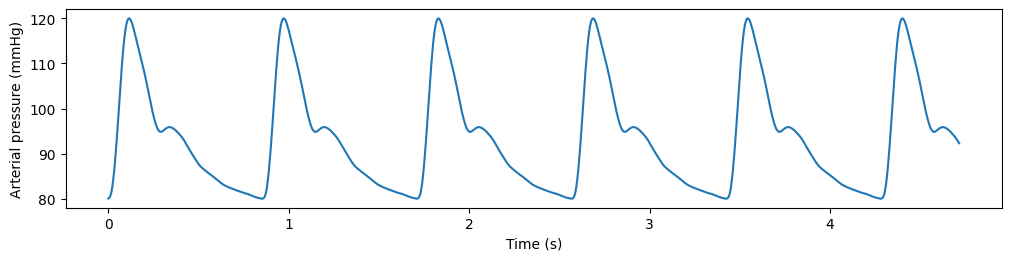

In [4]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data.time, data.pressure)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

### Load the data into `medical_waveforms`

In [5]:
wf = Waveforms(data)

### Find troughs in a waveform

In this case, we use the troughs to split our arterial blood pressure data into separate heartbeats.

NB. Specifying the `scale` argument of `find_troughs` can save lots of memory if your data contain many cycles. Here I set it to (very approximately) half of the cycle length.

In [6]:
wf = find_troughs(wf, name='pressure', scale=100)

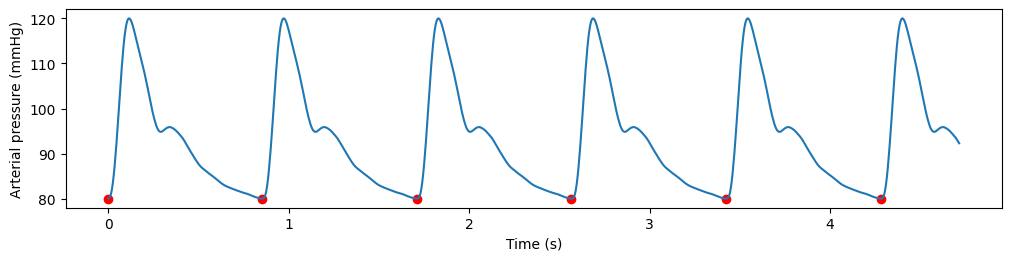

In [7]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data.time, data.pressure)
ax.scatter(
    data.time[wf.features.waveform['pressure']['troughs']],
    data.pressure[wf.features.waveform['pressure']['troughs']],
    color='red',
)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

### Calculate per-heartbeat features

In [8]:
for feature_extractor in [
    cycles.Duration,
    cycles.CyclesPerMinute,
    cycles.MaximumValue,
    cycles.MinimumValue,
    cycles.MeanValue,
    cycles.MaximumMinusMinimumValue,
    cycles.MeanNegativeFirstDifference
]:
    wf = feature_extractor().extract_feature(wf, 'pressure')

In [9]:
wf.features.cycles

{'pressure': {'Duration': array([0.85 , 0.86 , 0.855, 0.86 , 0.855]),
  'CyclesPerMinute': array([70.58823529, 69.76744186, 70.1754386 , 69.76744186, 70.1754386 ]),
  'MaximumValue': array([120.        , 119.97736746, 119.99709951, 119.99027587,
         119.98921318]),
  'MinimumValue': array([80.00332686, 80.00103817, 80.00103817, 80.00115878, 80.        ]),
  'MeanValue': array([92.64628119, 92.50011353, 92.57275326, 92.50011546, 92.57275413]),
  'MaximumMinusMinimumValue': array([39.99667314, 39.97632929, 39.99606134, 39.98911708, 39.98921318]),
  'MeanNegativeFirstDifference': array([-0.2996558 , -0.29514956, -0.2996549 , -0.29734221, -0.29958959])}}

## Signal quality assessment

### Make noisy synthetic data

Now, we generate some synthetic arterial pressure data which is corrupted by a line flush-type artifact. We can use medical-waveforms to assess signal quality for each beat of these data.

In [10]:
data_with_flush = synthetic_arterial_pressure_data(
    systolic_pressure=120,
    diastolic_pressure=80,
    heart_rate=60,
    n_beats_target=8.3,
    hertz=100
)

data_with_flush.loc[
    330:460,
    "pressure"
] += 300.0

In [11]:
wf_with_flush = Waveforms(data_with_flush)
wf_with_flush = find_troughs(wf_with_flush, "pressure", scale=50)

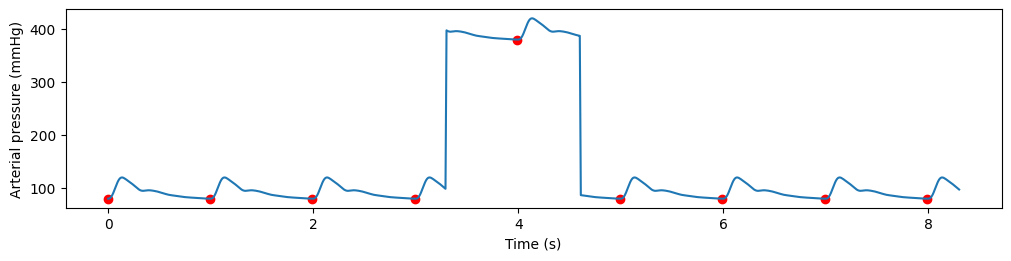

In [12]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data_with_flush.time, data_with_flush.pressure)
ax.scatter(
    data_with_flush.time[wf_with_flush.features.waveform['pressure']['troughs']],
    data_with_flush.pressure[wf_with_flush.features.waveform['pressure']['troughs']],
    color='red',
)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

### Assess signal quality

Load some preset checks:

In [13]:
checks = quality.ArterialPressureChecks()

Check each cycle:

In [14]:
check_results = quality.check_cycles(wf_with_flush, "pressure", checks)
check_results

,diastolic_pressure,systolic_pressure,mean_pressure,heart_rate,pulse_pressure,mean_dyneg,diastolic_pressure_diff,systolic_pressure_diff,beat_time_diff,all
0,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True
3,True,False,False,True,False,True,True,False,True,False
4,True,False,False,True,False,False,True,False,True,False
5,True,True,True,True,True,True,True,False,True,False
6,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True


### Plot results

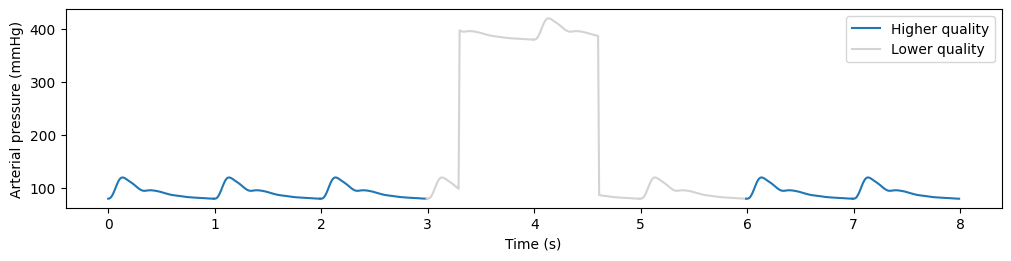

In [15]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)

for cycle_i, cycle in enumerate(cycles.get_cycles(wf_with_flush, "pressure")):
    if check_results.loc[cycle_i, 'all'].squeeze():
        colour='tab:blue'
    else:
        colour='lightgray'
    ax.plot(cycle.time, cycle.pressure, c=colour)

custom_lines = [Line2D([0], [0], color='tab:blue'),
                Line2D([0], [0], color='lightgray')]
ax.legend(custom_lines, ['Higher quality', 'Lower quality'])

ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()